**Imports and setup**

**This cell imports all required libraries and sets up the environment.**

It loads PyTorch, neural-network components, optimization tools, dataset utilities, and any helper functions needed for training the models.

In [1]:
# 1. Imports and Setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

sns.set_palette("colorblind")  # for accessibility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Load Fashion-MNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root=".", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

classes = train_data.classes
print("Classes:", classes)

# 3. Generic MLP class

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128], num_classes=10):
        super().__init__()
        layers = []
        prev = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h

        layers.append(nn.Linear(prev, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

# 4. Training and Evaluation

def evaluate(model, data_loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return correct / total

def train(model, train_loader, test_loader, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        test_acc = evaluate(model, test_loader)

        train_acc_hist.append(train_acc)
        test_acc_hist.append(test_acc)

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

    return train_acc_hist, test_acc_hist

def plot_curves(train_acc, test_acc, title):
    plt.figure(figsize=(7,4))
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.65MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


**Baseline MLP model**

**This cell defines and trains the baseline MLP model.**

The baseline uses a simple architecture and serves as a reference point for later experiments.
After training, it stores the resulting training and test accuracy.

Epoch 1 | Train Acc: 0.819 | Test Acc: 0.845
Epoch 2 | Train Acc: 0.861 | Test Acc: 0.856
Epoch 3 | Train Acc: 0.873 | Test Acc: 0.864
Epoch 4 | Train Acc: 0.882 | Test Acc: 0.872
Epoch 5 | Train Acc: 0.889 | Test Acc: 0.868
Epoch 6 | Train Acc: 0.893 | Test Acc: 0.870
Epoch 7 | Train Acc: 0.899 | Test Acc: 0.869
Epoch 8 | Train Acc: 0.904 | Test Acc: 0.872
Epoch 9 | Train Acc: 0.905 | Test Acc: 0.875
Epoch 10 | Train Acc: 0.911 | Test Acc: 0.881


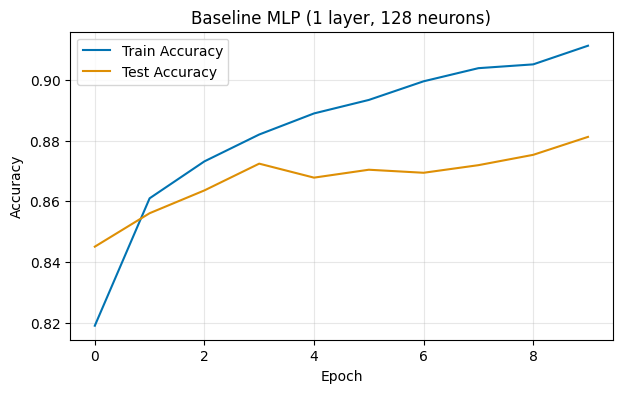

Baseline Final Test Accuracy: 0.8812


In [2]:
# Experiment 0 — Baseline MLP

baseline_model = MLP(hidden_sizes=[128])

baseline_train_acc, baseline_test_acc = train(
    baseline_model, train_loader, test_loader, epochs=10
)

plot_curves(baseline_train_acc, baseline_test_acc,
            "Baseline MLP (1 layer, 128 neurons)")

baseline_final_acc = evaluate(baseline_model, test_loader)
print("Baseline Final Test Accuracy:", baseline_final_acc)


**Experiment 1: Varying model depth**

**This cell runs the experiment that varies the depth of the MLP.**

For each architecture (1 layer, 2 layers, 3 layers…), it trains a model and records the test accuracy.
The results will be compared to evaluate how model depth affects performance.


Training: 1 layer [128]
Epoch 1 | Train Acc: 0.820 | Test Acc: 0.838
Epoch 2 | Train Acc: 0.863 | Test Acc: 0.852
Epoch 3 | Train Acc: 0.873 | Test Acc: 0.858
Epoch 4 | Train Acc: 0.883 | Test Acc: 0.860
Epoch 5 | Train Acc: 0.888 | Test Acc: 0.864
Epoch 6 | Train Acc: 0.894 | Test Acc: 0.866
Epoch 7 | Train Acc: 0.898 | Test Acc: 0.875
Epoch 8 | Train Acc: 0.902 | Test Acc: 0.876
Epoch 9 | Train Acc: 0.907 | Test Acc: 0.874
Epoch 10 | Train Acc: 0.909 | Test Acc: 0.881


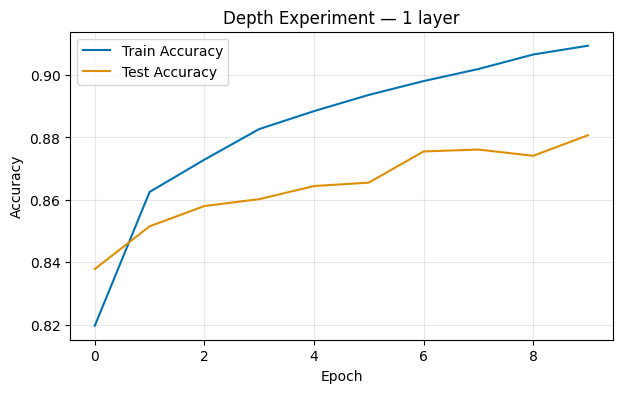


Training: 2 layers [128, 128]
Epoch 1 | Train Acc: 0.816 | Test Acc: 0.847
Epoch 2 | Train Acc: 0.862 | Test Acc: 0.849
Epoch 3 | Train Acc: 0.875 | Test Acc: 0.866
Epoch 4 | Train Acc: 0.885 | Test Acc: 0.873
Epoch 5 | Train Acc: 0.891 | Test Acc: 0.880
Epoch 6 | Train Acc: 0.896 | Test Acc: 0.870
Epoch 7 | Train Acc: 0.902 | Test Acc: 0.880
Epoch 8 | Train Acc: 0.906 | Test Acc: 0.880
Epoch 9 | Train Acc: 0.909 | Test Acc: 0.880
Epoch 10 | Train Acc: 0.912 | Test Acc: 0.882


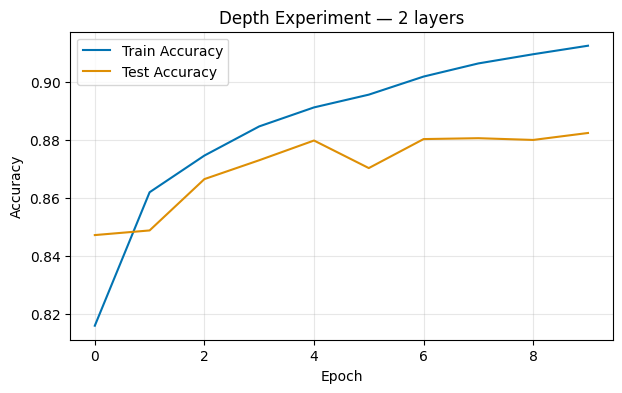


Training: 3 layers [128, 128, 128]
Epoch 1 | Train Acc: 0.811 | Test Acc: 0.826
Epoch 2 | Train Acc: 0.860 | Test Acc: 0.859
Epoch 3 | Train Acc: 0.875 | Test Acc: 0.866
Epoch 4 | Train Acc: 0.883 | Test Acc: 0.869
Epoch 5 | Train Acc: 0.890 | Test Acc: 0.874
Epoch 6 | Train Acc: 0.895 | Test Acc: 0.874
Epoch 7 | Train Acc: 0.899 | Test Acc: 0.873
Epoch 8 | Train Acc: 0.903 | Test Acc: 0.879
Epoch 9 | Train Acc: 0.905 | Test Acc: 0.881
Epoch 10 | Train Acc: 0.910 | Test Acc: 0.880


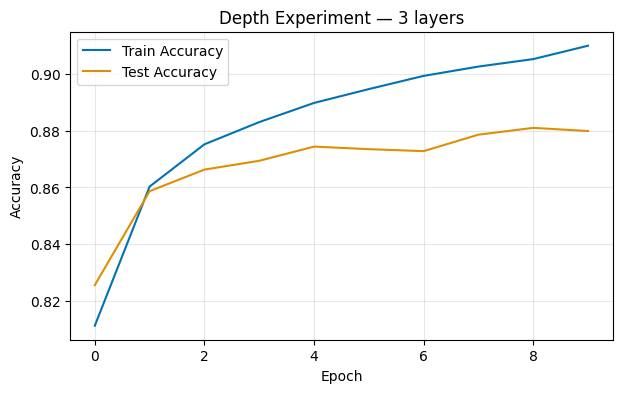


Training: 4 layers [128, 128, 128, 128]
Epoch 1 | Train Acc: 0.799 | Test Acc: 0.833
Epoch 2 | Train Acc: 0.853 | Test Acc: 0.854
Epoch 3 | Train Acc: 0.871 | Test Acc: 0.863
Epoch 4 | Train Acc: 0.879 | Test Acc: 0.855
Epoch 5 | Train Acc: 0.886 | Test Acc: 0.874
Epoch 6 | Train Acc: 0.892 | Test Acc: 0.869
Epoch 7 | Train Acc: 0.896 | Test Acc: 0.880
Epoch 8 | Train Acc: 0.900 | Test Acc: 0.879
Epoch 9 | Train Acc: 0.905 | Test Acc: 0.881
Epoch 10 | Train Acc: 0.908 | Test Acc: 0.875


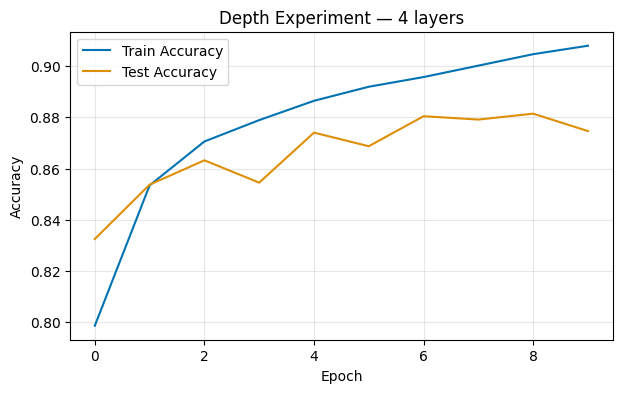

In [4]:
# Experiment 1 — Varying Depth

depth_configs = {
    "1 layer": [128],
    "2 layers": [128, 128],
    "3 layers": [128, 128, 128],
    "4 layers": [128, 128, 128, 128]
}

results_depth = {}

for name, hidden_sizes in depth_configs.items():
    print("\nTraining:", name, hidden_sizes)
    model = MLP(hidden_sizes=hidden_sizes)
    train_acc, test_acc = train(model, train_loader, test_loader, epochs=10)
    results_depth[name] = test_acc[-1]

    plot_curves(train_acc, test_acc, f"Depth Experiment — {name}")


**Depth experiment plot**

**This cell visualizes the results of Experiment 1.**

It creates a bar plot showing how test accuracy changes as the number of layers increases.

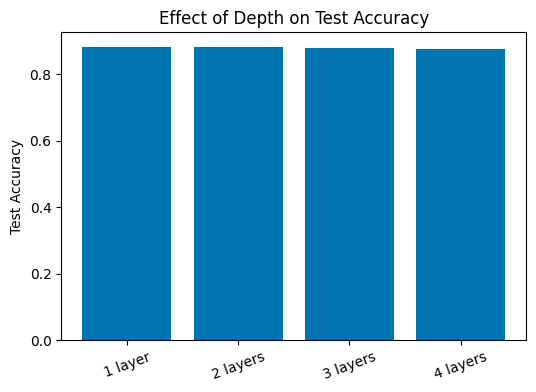

In [5]:
plt.figure(figsize=(6,4))
plt.bar(results_depth.keys(), results_depth.values())
plt.title("Effect of Depth on Test Accuracy")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=20)
plt.show()


**Experiment 2: Varying model width**

**This cell runs the experiment that varies the width (number of neurons per layer).**

For each width value, the model is trained and its test accuracy is recorded.
This allows evaluation of how network size affects performance.


Training: Width = 64
Epoch 1 | Train Acc: 0.814 | Test Acc: 0.833
Epoch 2 | Train Acc: 0.857 | Test Acc: 0.852
Epoch 3 | Train Acc: 0.868 | Test Acc: 0.862
Epoch 4 | Train Acc: 0.877 | Test Acc: 0.862
Epoch 5 | Train Acc: 0.883 | Test Acc: 0.868
Epoch 6 | Train Acc: 0.889 | Test Acc: 0.868
Epoch 7 | Train Acc: 0.891 | Test Acc: 0.875
Epoch 8 | Train Acc: 0.895 | Test Acc: 0.868
Epoch 9 | Train Acc: 0.898 | Test Acc: 0.878
Epoch 10 | Train Acc: 0.901 | Test Acc: 0.877


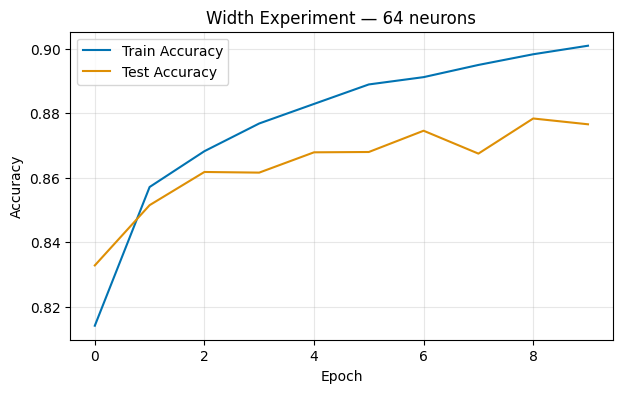


Training: Width = 128
Epoch 1 | Train Acc: 0.819 | Test Acc: 0.846
Epoch 2 | Train Acc: 0.859 | Test Acc: 0.853
Epoch 3 | Train Acc: 0.873 | Test Acc: 0.846
Epoch 4 | Train Acc: 0.882 | Test Acc: 0.868
Epoch 5 | Train Acc: 0.888 | Test Acc: 0.868
Epoch 6 | Train Acc: 0.894 | Test Acc: 0.875
Epoch 7 | Train Acc: 0.898 | Test Acc: 0.869
Epoch 8 | Train Acc: 0.902 | Test Acc: 0.869
Epoch 9 | Train Acc: 0.906 | Test Acc: 0.881
Epoch 10 | Train Acc: 0.910 | Test Acc: 0.879


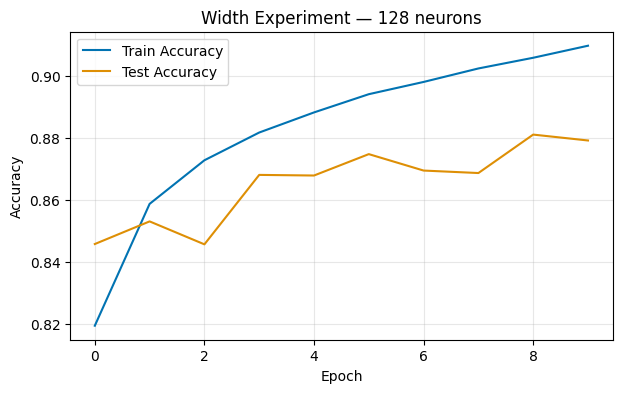


Training: Width = 256
Epoch 1 | Train Acc: 0.825 | Test Acc: 0.833
Epoch 2 | Train Acc: 0.864 | Test Acc: 0.861
Epoch 3 | Train Acc: 0.878 | Test Acc: 0.865
Epoch 4 | Train Acc: 0.887 | Test Acc: 0.873
Epoch 5 | Train Acc: 0.893 | Test Acc: 0.863
Epoch 6 | Train Acc: 0.898 | Test Acc: 0.871
Epoch 7 | Train Acc: 0.904 | Test Acc: 0.877
Epoch 8 | Train Acc: 0.908 | Test Acc: 0.871
Epoch 9 | Train Acc: 0.912 | Test Acc: 0.881
Epoch 10 | Train Acc: 0.915 | Test Acc: 0.882


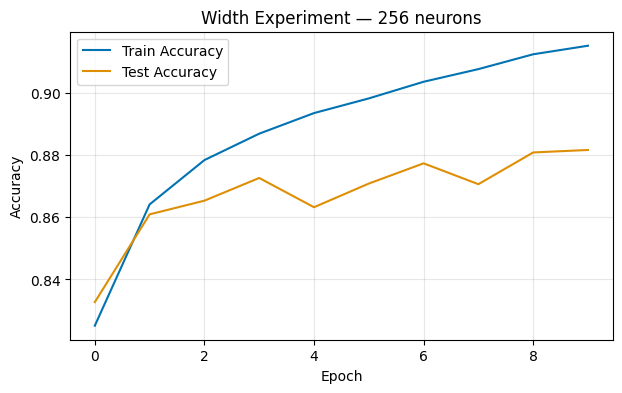


Training: Width = 512
Epoch 1 | Train Acc: 0.826 | Test Acc: 0.835
Epoch 2 | Train Acc: 0.865 | Test Acc: 0.861
Epoch 3 | Train Acc: 0.878 | Test Acc: 0.868
Epoch 4 | Train Acc: 0.887 | Test Acc: 0.874
Epoch 5 | Train Acc: 0.895 | Test Acc: 0.868
Epoch 6 | Train Acc: 0.900 | Test Acc: 0.876
Epoch 7 | Train Acc: 0.905 | Test Acc: 0.873
Epoch 8 | Train Acc: 0.910 | Test Acc: 0.883
Epoch 9 | Train Acc: 0.914 | Test Acc: 0.876
Epoch 10 | Train Acc: 0.917 | Test Acc: 0.881


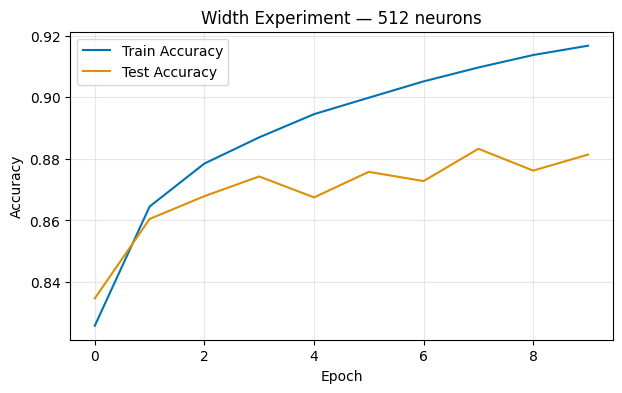

In [6]:
# Experiment 2 — Varying Width

width_values = [64, 128, 256, 512]
results_width = {}

for width in width_values:
    print(f"\nTraining: Width = {width}")
    model = MLP(hidden_sizes=[width])
    train_acc, test_acc = train(model, train_loader, test_loader, epochs=10)

    results_width[width] = test_acc[-1]

    plot_curves(train_acc, test_acc, f"Width Experiment — {width} neurons")


**Width experiment plot**

**This cell visualizes the results of Experiment 2.**

It creates a bar chart showing how test accuracy changes as model width increases.

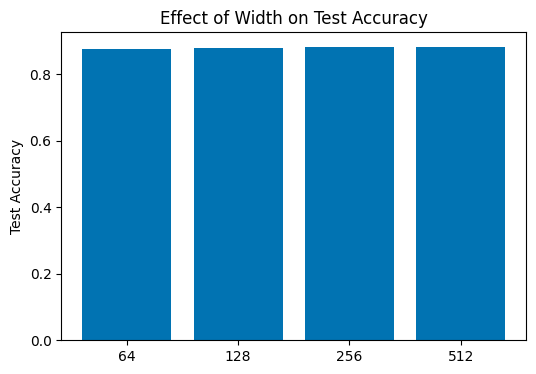

In [7]:
plt.figure(figsize=(6,4))
plt.bar([str(w) for w in width_values], results_width.values())
plt.title("Effect of Width on Test Accuracy")
plt.ylabel("Test Accuracy")
plt.show()


**Confusion matrix for best model**

This cell identifies the best-performing model and computes its
confusion matrix on the test set.  

The confusion matrix helps analyze which classes the model predicts well and which classes it confuses.

Epoch 1 | Train Acc: 0.825 | Test Acc: 0.841
Epoch 2 | Train Acc: 0.864 | Test Acc: 0.862
Epoch 3 | Train Acc: 0.878 | Test Acc: 0.865
Epoch 4 | Train Acc: 0.887 | Test Acc: 0.875
Epoch 5 | Train Acc: 0.893 | Test Acc: 0.872
Epoch 6 | Train Acc: 0.899 | Test Acc: 0.877
Epoch 7 | Train Acc: 0.904 | Test Acc: 0.882
Epoch 8 | Train Acc: 0.907 | Test Acc: 0.886
Epoch 9 | Train Acc: 0.912 | Test Acc: 0.878
Epoch 10 | Train Acc: 0.915 | Test Acc: 0.883


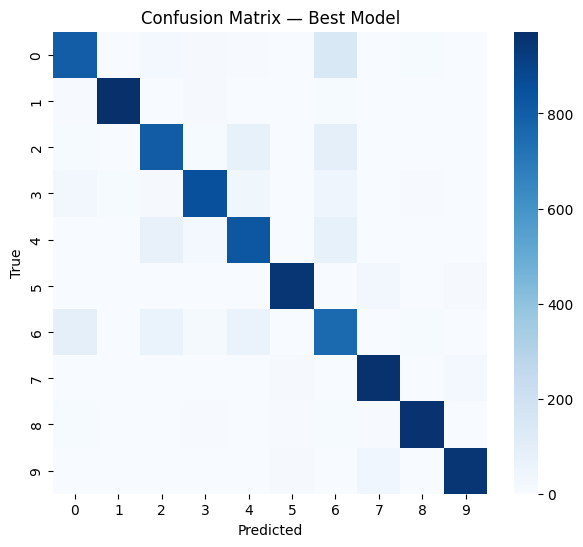

In [8]:
# Confusion Matrix (Best Model)

best_width = max(results_width, key=results_width.get)
best_model = MLP(hidden_sizes=[best_width])
train(best_model, train_loader, test_loader, epochs=10)

# Generate predictions
all_preds = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix — Best Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
